<a href="https://colab.research.google.com/github/max-poltora/fertilizer_particles_recognizer/blob/main/Unet_fertilizer_particles_val_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


Import libraries for preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from random import shuffle
from random import randint

In [ ]:
imgdir = '/content/drive/MyDrive/Colab Notebooks/Fertilizer particles/Images'
mskdir = '/content/drive/MyDrive/Colab Notebooks/Fertilizer particles/Masks'


In [ ]:
batch_size = 10
img_width = 512
img_height = 512
img_channels = 3

def image_generator(files, batch_size = batch_size, target_size = (img_width, img_height)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for file in batch:

        #get and preprocess images 
        img = Image.open(f'{imgdir}/{file}')
        img = np.array(img.resize(target_size))

        batch_x.append(img)
        
        #get and preprocess masks 
        msk = Image.open(f'{mskdir}/{file}')
        msk = msk.convert('1')
        msk = np.array(msk.resize(target_size))

        batch_y.append(msk)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.expand_dims(batch_y, 3)

    yield (batch_x, batch_y)      
    

In [ ]:
all_files = os.listdir(imgdir)
shuffle(all_files)

split = int(0.8 * len(all_files)) # 80%

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files)
test_generator  = image_generator(test_files)

Sample of training dataset

In [ ]:
x, y = next(train_generator)

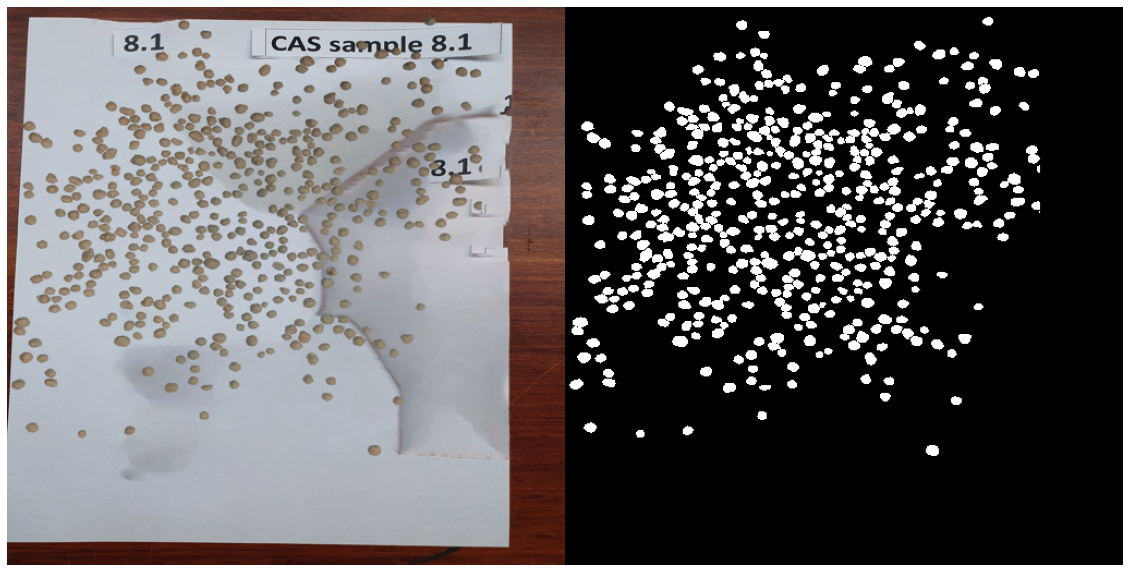

In [ ]:
plt.figure(figsize=(20,20))
plt.axis('off')
n = randint(0, batch_size-1)
img = x[n]
msk = y[n].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow(np.concatenate([img, msk], axis = 1))


Import libraries for the model

In [ ]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K


Define Unet model

In [ ]:
def unet(pretrained_weights=None, input_size=(img_width, img_height, img_channels)):
  
  input = Input(input_size)

  # Contraction path
  c1 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(input)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPool2D(pool_size=(2,2))(c1)

  c2 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPool2D(pool_size=(2,2))(c2)

  c3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPool2D(pool_size=(2,2))(c3)

  c4 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPool2D(pool_size=(2,2))(c4)

  c5 = Conv2D(filters=1024, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(filters=1024, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  # Upsampling path
  u6 = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding="same")(c5) 
  merge6 = concatenate([u6, c4])
  c6 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="same")(c6) 
  merge7 = concatenate([u7, c3])
  c7 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding="same")(c7) 
  merge8 = concatenate([u8, c2])
  c8 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="same")(c8) 
  merge9 = concatenate([u9, c1])
  c9 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  output = Conv2D(filters=1, kernel_size=(1,1), activation="sigmoid")(c9)

  model = Model(inputs=input, outputs=output)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  if(pretrained_weights):
    	model.load_weights(pretrained_weights)

  # model.summary()

  return model

model = unet(pretrained_weights = '/content/drive/MyDrive/Fertilizer particles recognizer_full dataset.h5')
# model = unet()

Callbacks

In [ ]:
callbacks = [
             EarlyStopping(patience=2),
             ModelCheckpoint(filepath='/content/drive/MyDrive/Fertilizer particles recognizer_full dataset.h5', 
                             verbose=0, save_best_only=True, save_weights_only=True, monitor='val_loss')
]

Training

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = callbacks,
                    initial_epoch = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 18/30
253/253 [==============================] - 5006s 20s/step - loss: 0.0133 - accuracy: 0.9946 - val_loss: 0.0139 - val_accuracy: 0.9950
Epoch 19/30
253/253 [==============================] - 2439s 10s/step - loss: 0.0119 - accuracy: 0.9951 - val_loss: 0.0138 - val_accuracy: 0.9948
Epoch 20/30
253/253 [==============================] - 1707s 7s/step - loss: 0.0160 - accuracy: 0.9937 - val_loss: 0.0155 - val_accuracy: 0.9943
Epoch 21/30
253/253 [==============================] - 1441s 6s/step - loss: 0.0124 - accuracy: 0.9949 - val_loss: 0.0137 - val_accuracy: 0.9951
Epoch 22/30
253/253 [==============================] - 1342s 5s/step - loss: 0.0113 - accuracy: 0.9953 - val_loss: 0.0121 - val_accuracy: 0.9954
Epoch 23/30
253/253 [==============================] - 1311s 5s/step - loss: 0.0108 - accuracy: 0.9955 - val_loss: 0.0116 - val_accuracy: 0.9954
Epoch 24/30
253/253 [==============================] - 1278s 5s/step - loss: 0.0108 - accuracy: 0.9955 - val_loss: 0.0118 - val_

Check results on testing dataset

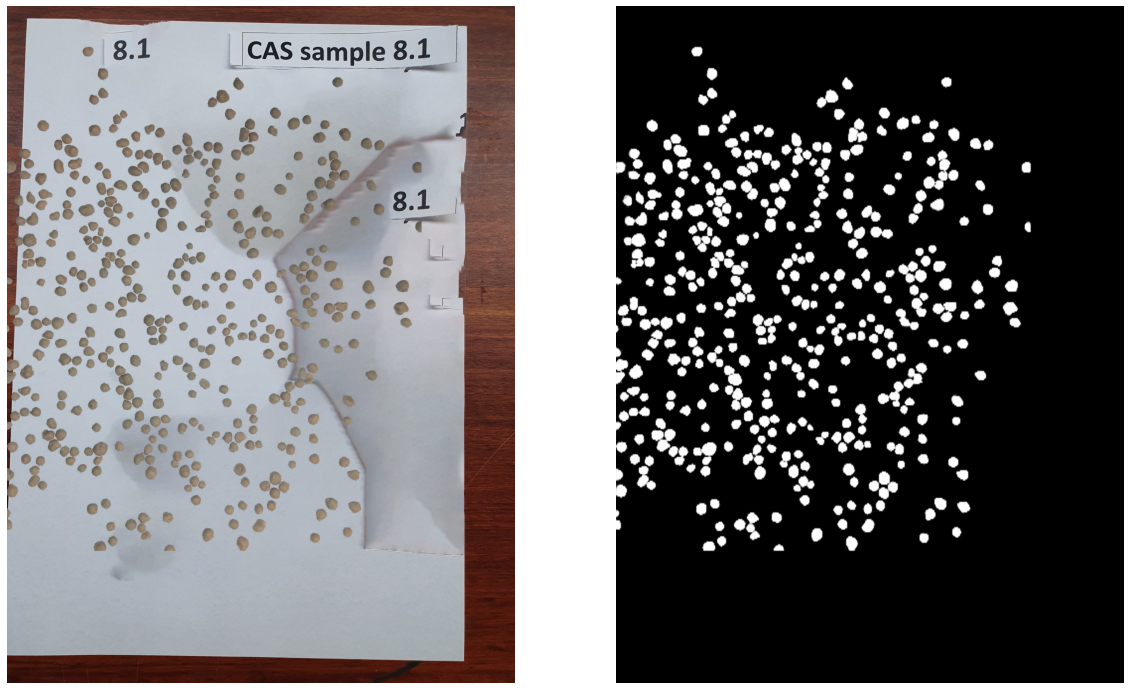

In [ ]:
path = np.random.choice(test_files)
raw = Image.open(f'{imgdir}/{path}')
w_ini, h_ini = raw.size
img = np.array(raw.resize((img_width, img_height)))/255.
img = img[:,:,0:3]
        
#predict the mask 
pred = model.predict(np.expand_dims(img, 0))
        
#mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)

# reshaping the mask, giving initial image width and height
msk = Image.fromarray((msk*255.).astype(np.uint8))
msk = msk.resize((w_ini, h_ini))

#show the mask and the segmented image 
f, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(raw)
ax[1].imshow(msk)

Validate the model on random picture

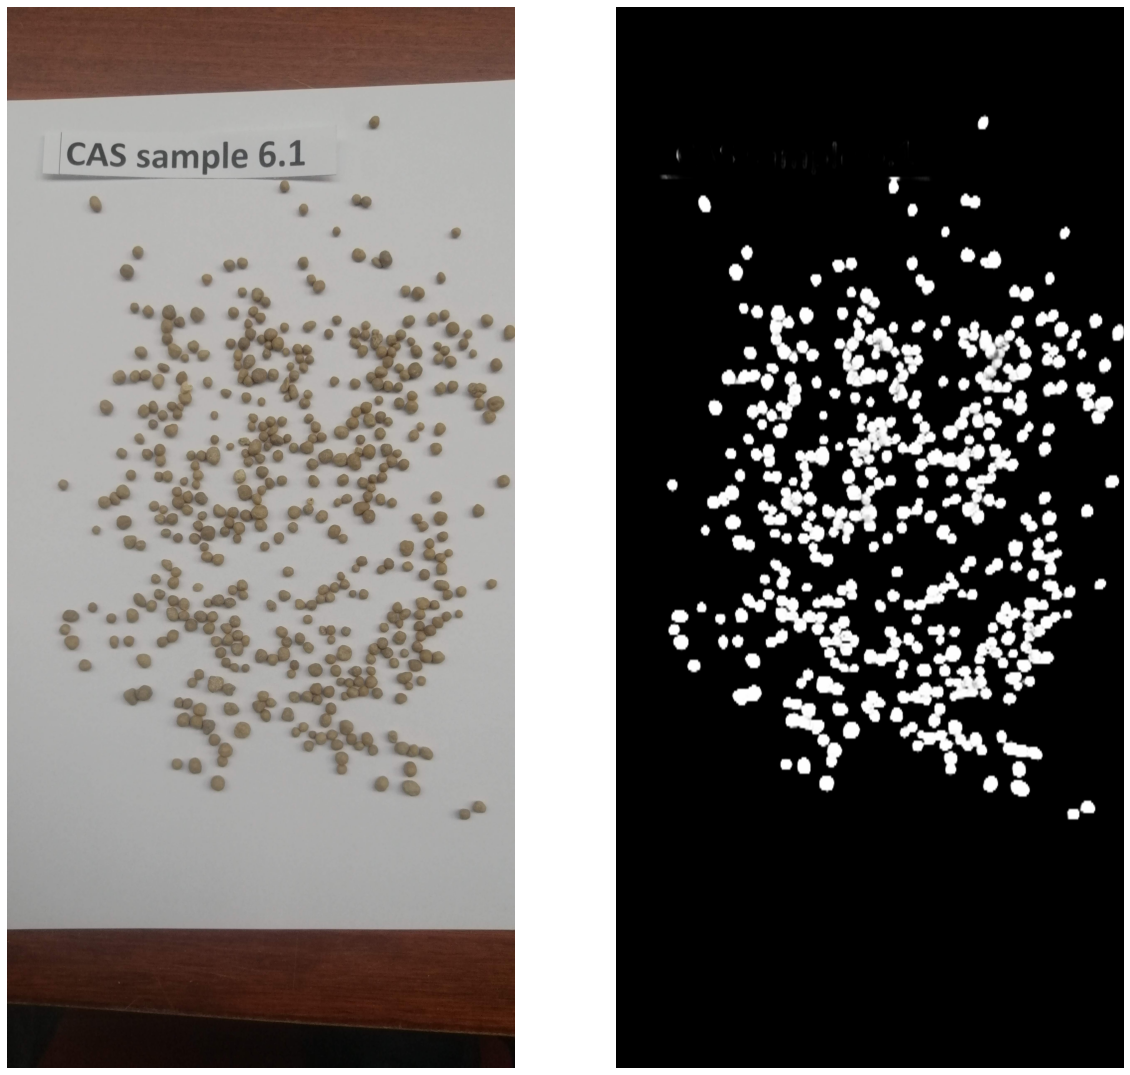

In [ ]:
valdir = '/content/drive/MyDrive/Colab Notebooks/Fertilizer particles/Validation images'
path = np.random.choice(os.listdir(valdir))
raw = Image.open(f'{valdir}/{path}')
w_ini, h_ini = raw.size
img = np.array(raw.resize((img_width, img_height)))/255.
img = img[:,:,0:3]
        
#predict the mask 
pred = model.predict(np.expand_dims(img, 0))
        
#mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)

# reshaping the mask, giving initial image width and height
msk = Image.fromarray((msk*255.).astype(np.uint8))
msk = msk.resize((w_ini, h_ini))

#show the mask and the segmented image 
f, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(raw)
ax[1].imshow(msk)

In [ ]:
path = np.random.choice(test_files)

msk = Image.open(f'{mskdir}/{path}')

msk = msk.convert('1')
unique, counts = np.unique(msk, return_counts=True)
pd.DataFrame({'Values': unique, 'Counts': counts})



,Values,Counts
0,False,11563875
1,True,628893
